We connect to google drive where the dataset has been stored

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We import the libraries that we are going to use

In [2]:
from PIL import Image
import requests
import os
from tqdm import tqdm
import numpy as np
import cv2
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import SamModel, SamProcessor
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
images = []
masks = []

images_path = os.path.join('/content/drive/MyDrive/Water Bodies Dataset/Images')
masks_path = os.path.join('/content/drive/MyDrive/Water Bodies Dataset/Masks')

sorted_image_files = sorted(os.listdir(images_path))
sorted_mask_files = sorted(os.listdir(masks_path))

for j in tqdm(sorted_image_files):
        img = cv2.imread(os.path.join(images_path,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(256,256))
        images.append(img)


for j in tqdm(sorted_mask_files):
        mask = cv2.imread(os.path.join(masks_path,j))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask,(256,256))
        masks.append(mask)

100%|██████████| 2841/2841 [15:50<00:00,  2.99it/s]


In [4]:
images = np.array(images)
masks = np.array(masks)
masks = (masks / 255.0).astype(np.uint8)

In [5]:
images.shape

(2841, 256, 256, 3)

In [6]:
masks.shape

(2841, 256, 256)

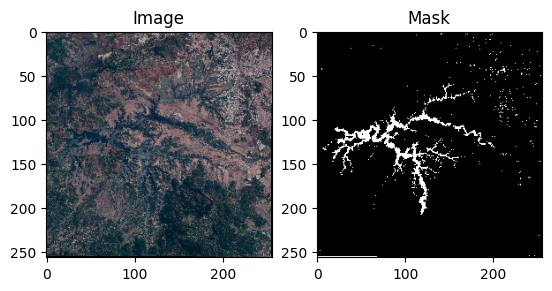

In [7]:
image = images[0]
mask = masks[0]

# Create a subplot with 1 row and 2 columns
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')  # Adjust cmap for colormap
plt.title("Mask")

# Show the plot
plt.show()

In [8]:
test_size = 0.1  # 10% of the data will be used for testing
random_state = 42  # Set a random seed for reproducibility

images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=test_size, random_state=random_state
)

# Print the sizes of the train and test sets
print(f"Number of training samples: {len(images_train)}")
print(f"Number of testing samples: {len(images_test)}")

Number of training samples: 2556
Number of testing samples: 285


In [10]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Transpose(p=0.5),
    A.RandomRotate90(p=0.5),
])

# Apply augmentations to the training set
train_images = []
train_masks = []

for img, mask in tqdm(zip(images_train, masks_train)):
    augmented = transform(image=img, mask=mask)
    train_images.append(augmented["image"])
    train_masks.append(augmented["mask"])

train_images = np.array(train_images)
train_masks = np.array(train_masks)


2556it [00:02, 1165.72it/s]


In [11]:
print(f"Number of training samples: {len(images_train)}")

Number of training samples: 2556


In [ ]:
!pip install datasets

In [13]:
from datasets import Dataset
from PIL import Image
import torch

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in train_images],
    "label": [Image.fromarray(mask) for mask in train_masks],
}

# Create a Dataset object
dataset = Dataset.from_dict(dataset_dict)


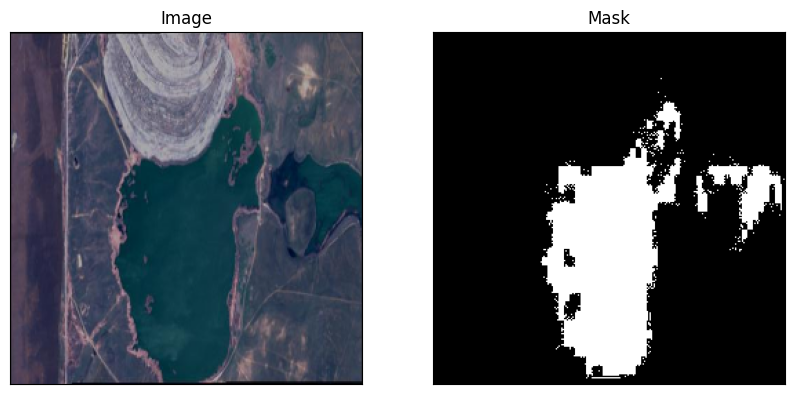

In [14]:
example_image = dataset[0]["image"]
example_mask = dataset[0]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [15]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [16]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [18]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [19]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [20]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [21]:
# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [54]:
def dice_coefficient(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    return (2.0 * intersection) / (union + intersection)

In [53]:
def iou(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum((y_true > 0) | (y_pred > 0))
    return intersection / union

In [ ]:
!pip install monai

In [30]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [31]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    epoch_IOU = []
    epoch_DICE = []
    for batch in tqdm(train_dataloader):
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Compute Dice coefficient and IoU
        dice = dice_coefficient(ground_truth_masks, predicted_masks)
        intersection_over_union = iou(ground_truth_masks, predicted_masks)
        epoch_DICE.append(dice.item())
        epoch_IOU.append(intersection_over_union.item())

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Print metrics after each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(epoch_losses):.4f}, Dice: {np.mean(epoch_DICE):.4f}, IoU: {np.mean(epoch_IOU):.4f}')



100%|██████████| 1278/1278 [20:37<00:00,  1.03it/s]


Epoch 1/5, Loss: 0.5423, Dice: 0.4016, IoU: 0.6042


100%|██████████| 1278/1278 [20:31<00:00,  1.04it/s]


Epoch 2/5, Loss: 0.5008, Dice: 0.3956, IoU: 0.6214


100%|██████████| 1278/1278 [20:29<00:00,  1.04it/s]


Epoch 3/5, Loss: 0.4808, Dice: 0.4050, IoU: 0.6476


100%|██████████| 1278/1278 [20:32<00:00,  1.04it/s]


Epoch 4/5, Loss: 0.4696, Dice: 0.3963, IoU: 0.7206


100%|██████████| 1278/1278 [20:37<00:00,  1.03it/s]

Epoch 5/5, Loss: 0.4433, Dice: 0.3738, IoU: 0.7385


In [32]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/SAM_model_checkpoint.pth")

In [34]:
from datasets import Dataset
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images_test],
    "label": [Image.fromarray(mask) for mask in masks_test],
}

# Create a Dataset object
test_set = Dataset.from_dict(dataset_dict)

In [72]:
test_dataset = SAMDataset(dataset=test_set, processor=processor)

# Create a DataLoader instance for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=False)

In [36]:
model.eval()  # Set the model to evaluation mode

test_losses = []
test_IOU = []
test_DICE = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # Move data to the device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"], input_boxes=batch["input_boxes"], multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float()
        test_loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
        test_losses.append(test_loss.item())

        # Compute Dice coefficient and IoU
        test_dice = dice_coefficient(ground_truth_masks, predicted_masks)
        test_iou = iou(ground_truth_masks, predicted_masks)
        test_DICE.append(test_dice.item())
        test_IOU.append(test_iou.item())

# Calculate mean values for loss, Dice, and IoU
mean_test_loss = np.mean(test_losses)
mean_test_dice = np.mean(test_DICE)
mean_test_iou = np.mean(test_IOU)

# Print the evaluation metrics
print(f'Test Loss: {mean_test_loss:.4f}, Test Dice: {mean_test_dice:.4f}, Test IoU: {mean_test_iou:.4f}')


100%|██████████| 143/143 [02:07<00:00,  1.13it/s]

Test Loss: 0.4221, Test Dice: 0.3102, Test IoU: 0.7478


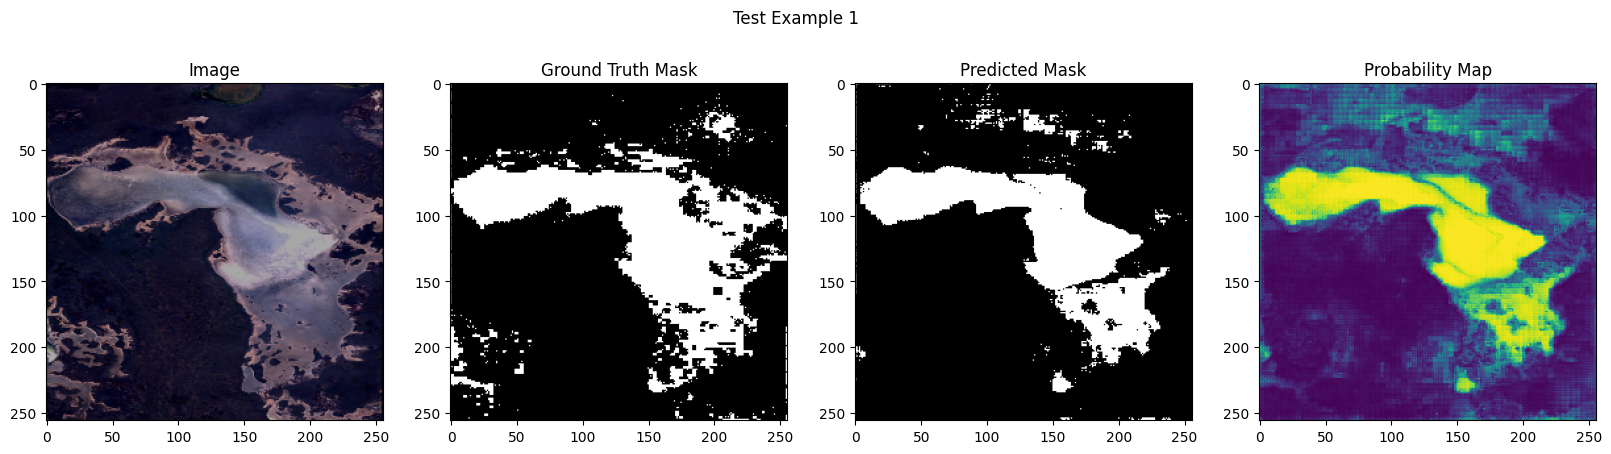

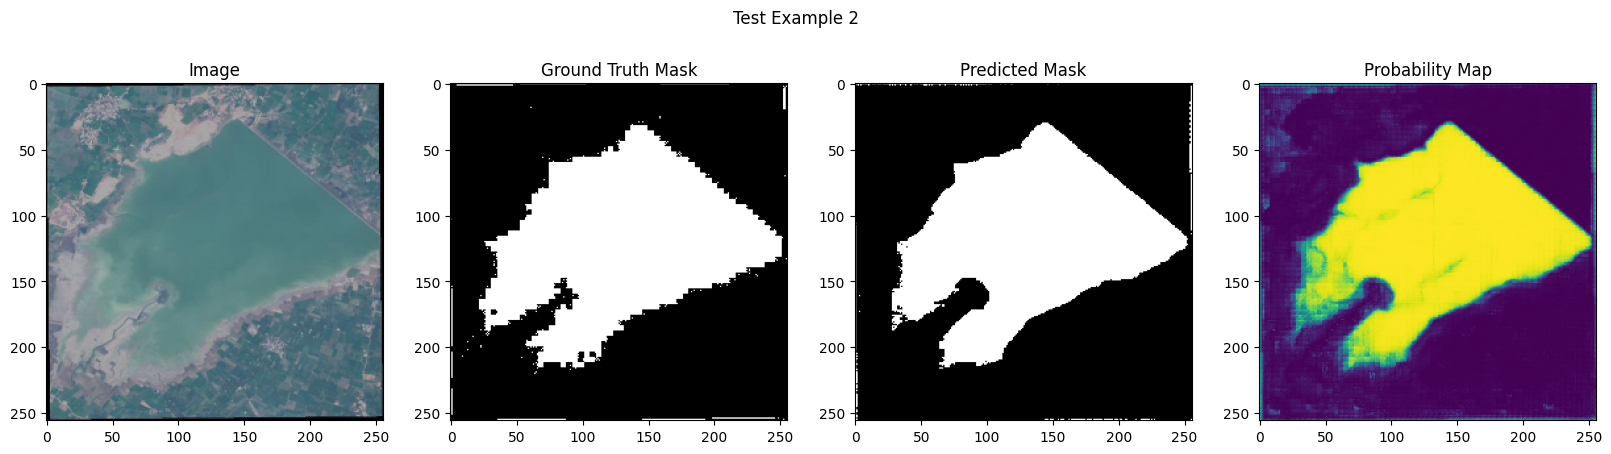

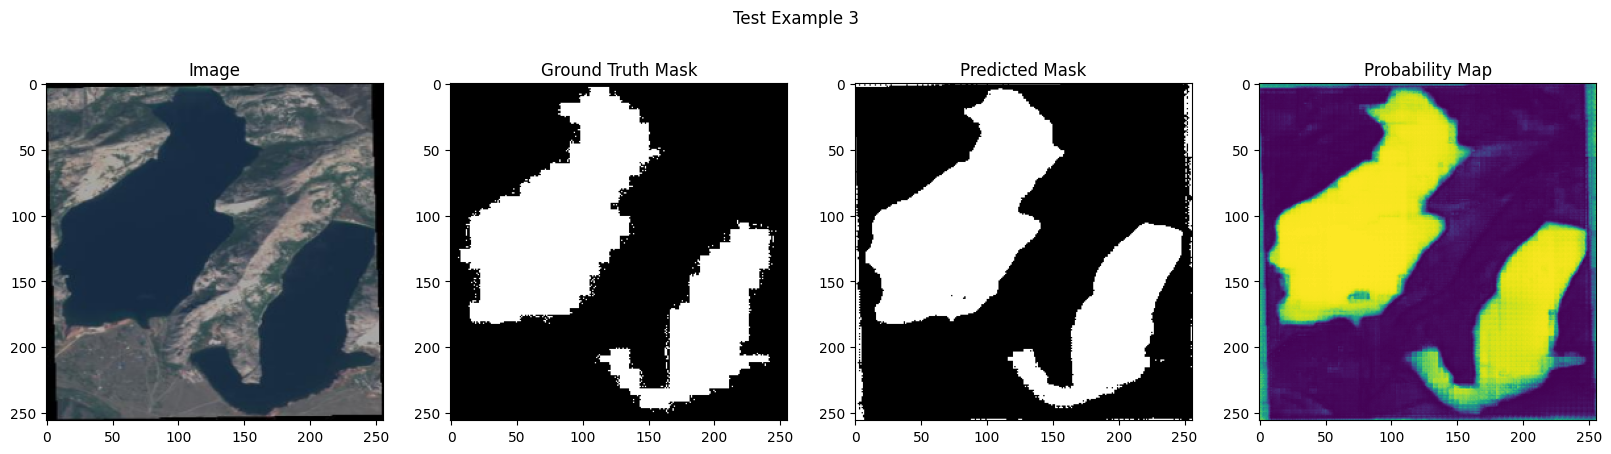

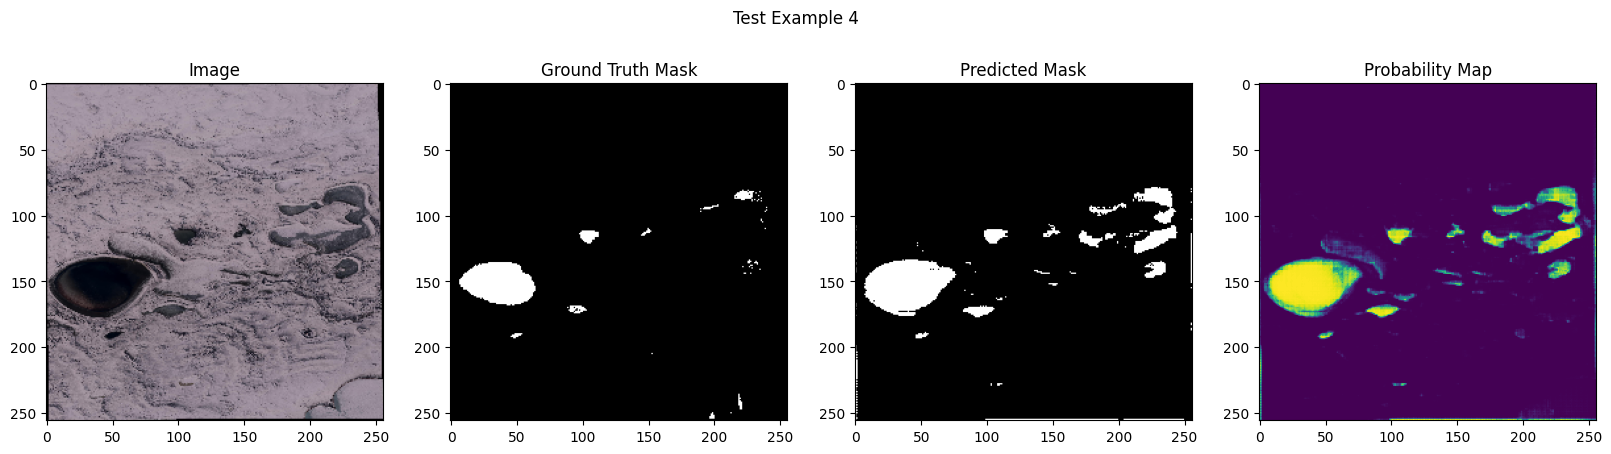

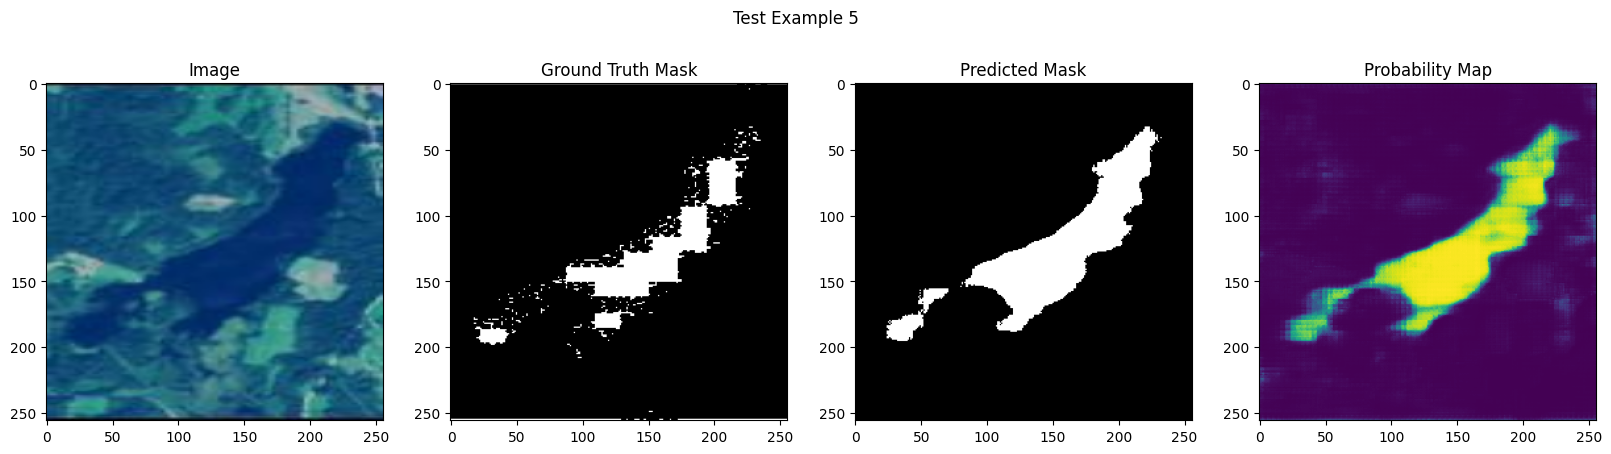

In [97]:
# Evaluation loop
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

with torch.no_grad():
    for idx in range(5):
        image = test_set[idx]["image"]
        mask = test_set[idx]["label"]

        box = get_bounding_box(np.array(mask))

        inputs = processor(image, input_boxes=[[box]], return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass to get predicted masks
        outputs = model(**inputs, multimask_output=False)
        predicted_masks = outputs.pred_masks.squeeze(1)

        # Calculate the probability map
        prob = torch.sigmoid(predicted_masks)
        prob = prob.cpu().numpy().squeeze()
        prediction = (prob > 0.5).astype(np.uint8)

        # Display images, masks, and probability map
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(image, cmap="gray")
        plt.title("Image")

        plt.subplot(1, 4, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Ground Truth Mask")

        plt.subplot(1, 4, 3)
        plt.imshow(prediction, cmap="gray")
        plt.title("Predicted Mask")

        plt.subplot(1, 4, 4)
        plt.imshow(prob)
        plt.title("Probability Map")

        plt.suptitle(f"Test Example {idx + 1}")
        plt.show()
